<a href="https://colab.research.google.com/github/aldyam/SentimentAnalysis_ProgramMBG/blob/main/FinalProgramMBG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TUGAS BESAR NLP: Analisis Sentimen & Emosi Opini Publik**
## **Topik: Program Makan Bergizi Gratis**

**Deskripsi:**
Notebook ini melakukan analisis bertahap mulai dari pelabelan sentimen dasar (Positif/Negatif) hingga emosi spesifik, dilanjutkan dengan pelatihan model AI.


### **1. Persiapan Data**
Install library, load data, dan pembersihan teks (*preprocessing*).

In [13]:
!pip install Sastrawi

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud

# 1. Load Data
file_name = 'program_makan_bergizi_gratis_10k_data.csv'
try:
    df = pd.read_csv(file_name)
    print(f"✅ Data Loaded: {df.shape[0]} rows.")
except:
    print("❌ File CSV belum diupload!")

# 2. Preprocessing
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = stopword.remove(text)
    return text

print("⏳ Cleaning data...")
df['text_clean'] = df['full_text'].apply(clean_text)
print("✅ Preprocessing Selesai!")

✅ Data Loaded: 10524 rows.
⏳ Cleaning data...
✅ Preprocessing Selesai!



## **PERTAMA : Analisis Label Polaritas (Positif/Negatif/Netral)**

Pada tahap ini, kita akan:
1.  Membuat label menggunakan Lexicon (Kamus).
2.  Melihat visualisasi dasar (Pie/Bar Chart & Word Cloud).
3.  Melatih dua model AI (Naive Bayes & LSTM) untuk memprediksi label ini.
4.  Mengevaluasi performa model dengan metrik lengkap.


📊 Visualisasi Label Polaritas:


/tmp/ipython-input-3929953618.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label_pol', data=df, palette='viridis', order=['Positif', 'Netral', 'Negatif'])


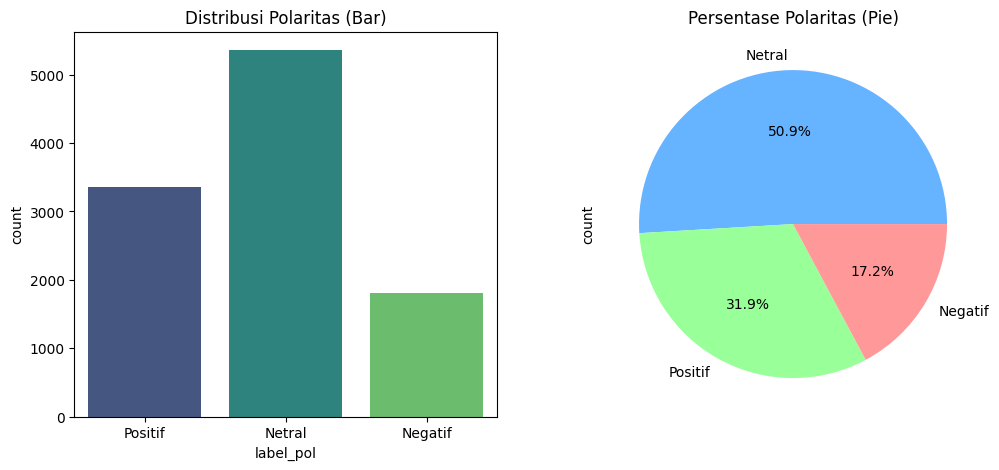

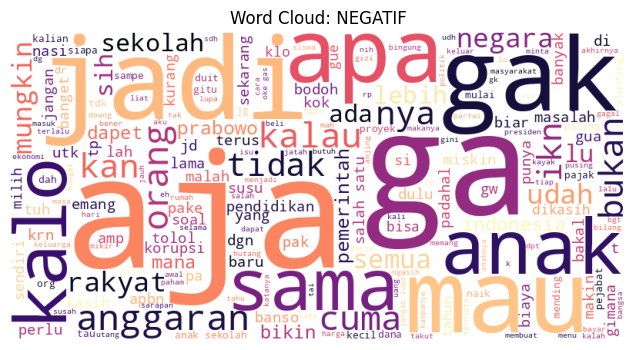

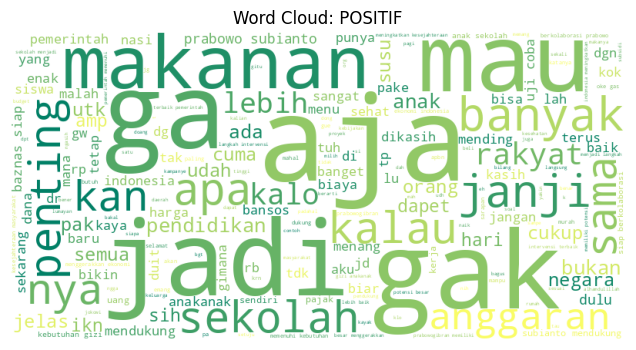


🤖 Sedang Melatih Model untuk Polaritas...
Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


132/132 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.5436 - loss: 0.9521
Epoch 2/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - accuracy: 0.7059 - loss: 0.6912
Epoch 3/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.8747 - loss: 0.3483

📈 --- HASIL EVALUASI LABEL POLARITAS ---


/tmp/ipython-input-3929953618.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Naive Bayes', 'LSTM (DL)'], y=[acc_ml*100, acc_dl*100], palette=['skyblue', 'orange'])


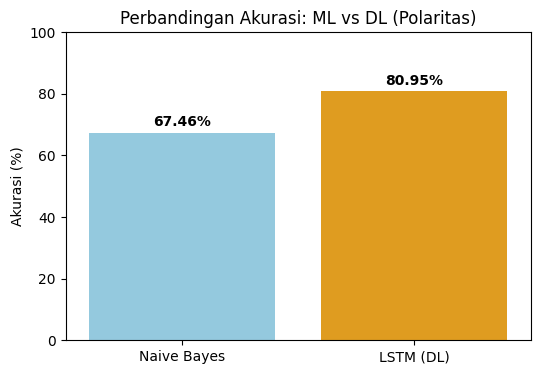

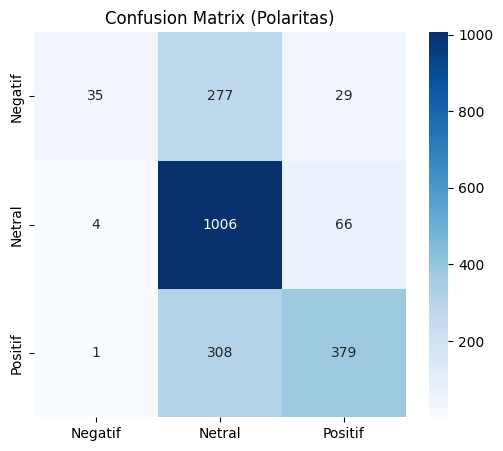

Detail Metrik Evaluasi:
              precision    recall  f1-score   support

     Negatif       0.88      0.10      0.18       341
      Netral       0.63      0.93      0.75      1076
     Positif       0.80      0.55      0.65       688

    accuracy                           0.67      2105
   macro avg       0.77      0.53      0.53      2105
weighted avg       0.73      0.67      0.63      2105



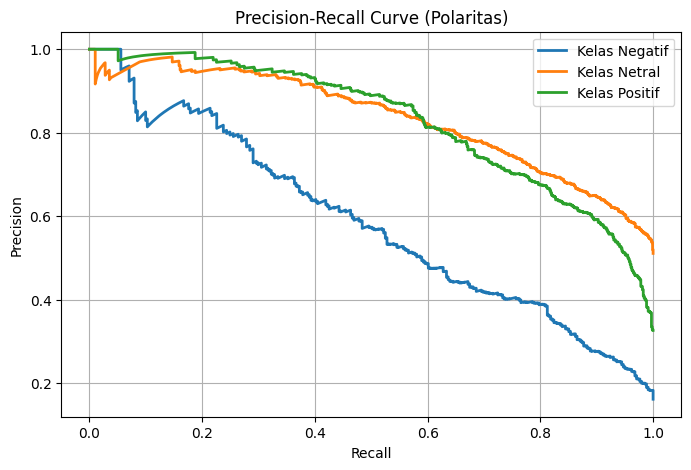

In [14]:
# --- A. LABELING LEXICON ---
!wget -q https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/positive.txt
!wget -q https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/negative.txt
with open('positive.txt', 'r') as f: pos = set(f.read().splitlines())
with open('negative.txt', 'r') as f: neg = set(f.read().splitlines())
for w in {'gratis', 'makan', 'program', 'anak', 'bergizi'}: pos.discard(w); neg.discard(w)

def get_polarity(text):
    score = 0
    for w in text.split():
        if w in pos: score += 1
        elif w in neg: score -= 1
    return 'Positif' if score > 0 else 'Negatif' if score < 0 else 'Netral'

df['label_pol'] = df['text_clean'].apply(get_polarity)

# --- B. VISUALISASI DASAR ---
print("\n📊 Visualisasi Label Polaritas:")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='label_pol', data=df, palette='viridis', order=['Positif', 'Netral', 'Negatif'])
plt.title('Distribusi Polaritas (Bar)')
plt.subplot(1, 2, 2)
df['label_pol'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#66b3ff','#99ff99','#ff9999'])
plt.title('Persentase Polaritas (Pie)')
plt.show()

# Word Cloud
stop_wc = {'makan', 'siang', 'gratis', 'program', 'yg', 'dan', 'ini', 'itu', 'buat', 'tapi', 'bergizi'}
def plot_wc(text, title, cmap):
    wc = WordCloud(width=800, height=400, background_color='white', stopwords=stop_wc, colormap=cmap).generate(' '.join(text.astype(str)))
    plt.figure(figsize=(8, 4)); plt.imshow(wc); plt.axis('off'); plt.title(title); plt.show()

plot_wc(df[df['label_pol']=='Negatif']['text_clean'], "Word Cloud: NEGATIF", 'magma')
plot_wc(df[df['label_pol']=='Positif']['text_clean'], "Word Cloud: POSITIF", 'summer')

# --- C. TRAINING MODEL (ML vs DL) ---
print("\n🤖 Sedang Melatih Model untuk Polaritas...")
# Split Data
X = df['text_clean'].astype(str)
y = df['label_pol']
le_pol = LabelEncoder()
y_enc = le_pol.fit_transform(y) # Jadi angka 0,1,2
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42)

# 1. Machine Learning (Naive Bayes)
vec = TfidfVectorizer(max_features=5000)
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)
model_nb = MultinomialNB()
model_nb.fit(X_train_vec, y_train)
y_pred_nb = model_nb.predict(X_test_vec)
acc_ml = accuracy_score(y_test, y_pred_nb)

# 2. Deep Learning (LSTM)
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(X)
X_lstm = pad_sequences(tokenizer.texts_to_sequences(X), maxlen=50)
X_tr_dl, X_te_dl, y_tr_dl, y_te_dl = train_test_split(X_lstm, pd.get_dummies(y_enc).values, test_size=0.2, random_state=42)

model_lstm = Sequential()
model_lstm.add(Embedding(5000, 100, input_length=50))
model_lstm.add(SpatialDropout1D(0.2))
model_lstm.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(3, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.fit(X_tr_dl, y_tr_dl, epochs=3, batch_size=64, verbose=1) # Epochs dikit aja biar cepet
acc_dl = model_lstm.evaluate(X_te_dl, y_te_dl, verbose=0)[1]

# --- D. EVALUASI LENGKAP (Output yang kamu minta) ---
print("\n📈 --- HASIL EVALUASI LABEL POLARITAS ---")

# 1. Perbandingan ML vs DL
plt.figure(figsize=(6, 4))
sns.barplot(x=['Naive Bayes', 'LSTM (DL)'], y=[acc_ml*100, acc_dl*100], palette=['skyblue', 'orange'])
plt.title('Perbandingan Akurasi: ML vs DL (Polaritas)')
plt.ylabel('Akurasi (%)'); plt.ylim(0, 100)
for i, v in enumerate([acc_ml*100, acc_dl*100]): plt.text(i, v+2, f"{v:.2f}%", ha='center', fontweight='bold')
plt.show()

# 2. Confusion Matrix (Untuk Naive Bayes)
cm = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_pol.classes_, yticklabels=le_pol.classes_)
plt.title('Confusion Matrix (Polaritas)')
plt.show()

# 3. Laporan Metrik (Accuracy, Recall, F1)
print("Detail Metrik Evaluasi:")
print(classification_report(y_test, y_pred_nb, target_names=le_pol.classes_))

# 4. Threshold (Precision-Recall Curve)
y_prob = model_nb.predict_proba(X_test_vec)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
plt.figure(figsize=(8, 5))
for i in range(3):
    prec, rec, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    plt.plot(rec, prec, lw=2, label=f'Kelas {le_pol.classes_[i]}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve (Polaritas)'); plt.legend(); plt.grid()
plt.show()


## **KE 2 : Analisis Label Emosi**

Tahap ini lebih kompleks karena kita memecah sentimen menjadi 5 kategori emosi. Output visualisasi dan evaluasi akan mengikuti format yang sama lengkapnya dengan Babak 1.


📊 Visualisasi Label Emosi:


/tmp/ipython-input-2838175274.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label_emo', data=df, palette='husl', order=df['label_emo'].value_counts().index)


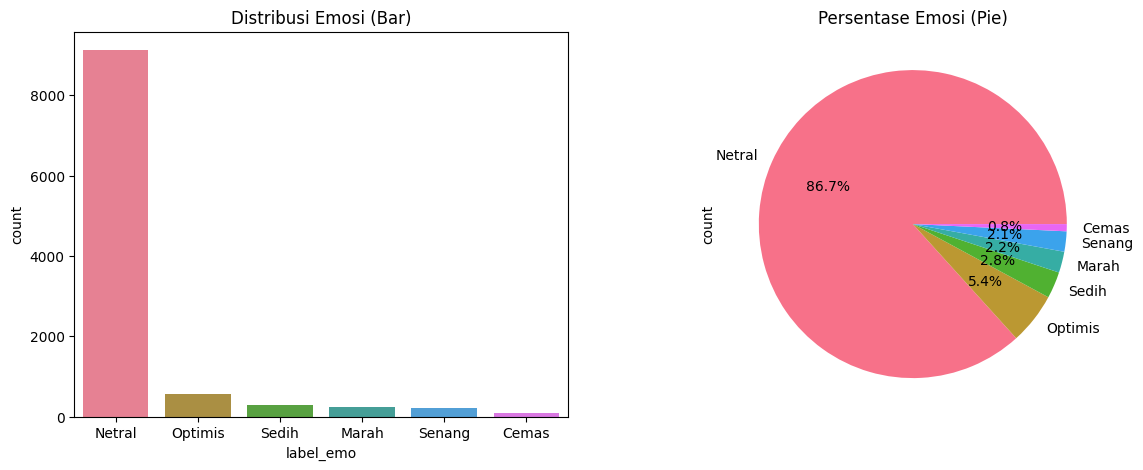

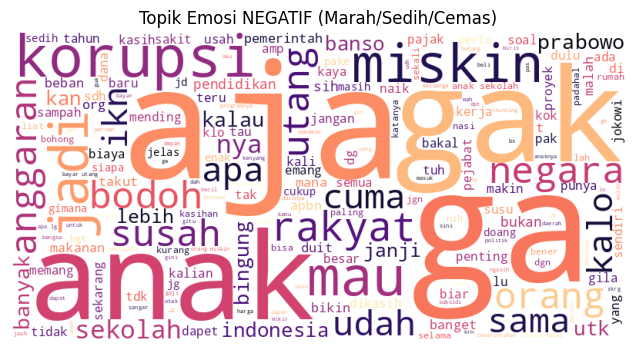

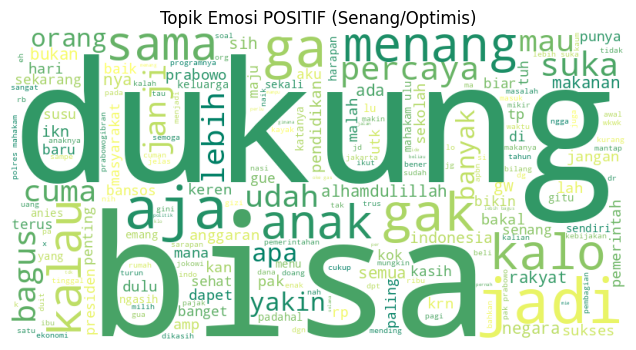


🤖 Sedang Melatih Model untuk Emosi (Mohon Tunggu)...
Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


132/132 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.8261 - loss: 0.8576
Epoch 2/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.8597 - loss: 0.5602
Epoch 3/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.8986 - loss: 0.3223

📈 --- HASIL EVALUASI LABEL EMOSI ---


/tmp/ipython-input-2838175274.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Naive Bayes', 'LSTM (DL)'], y=[acc_ml*100, acc_dl*100], palette=['skyblue', 'orange'])


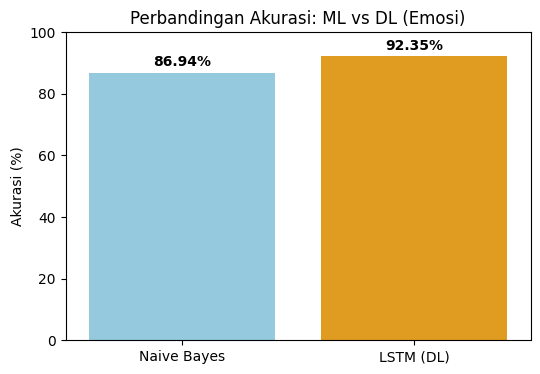

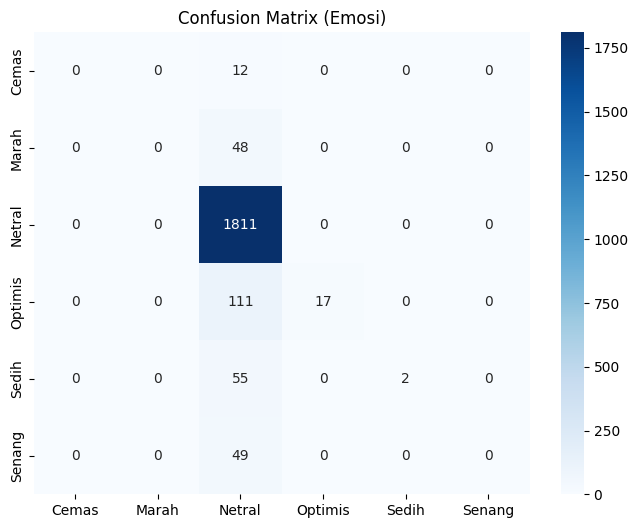

Detail Metrik Evaluasi:
              precision    recall  f1-score   support

       Cemas       0.00      0.00      0.00        12
       Marah       0.00      0.00      0.00        48
      Netral       0.87      1.00      0.93      1811
     Optimis       1.00      0.13      0.23       128
       Sedih       1.00      0.04      0.07        57
      Senang       0.00      0.00      0.00        49

    accuracy                           0.87      2105
   macro avg       0.48      0.19      0.21      2105
weighted avg       0.83      0.87      0.82      2105



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


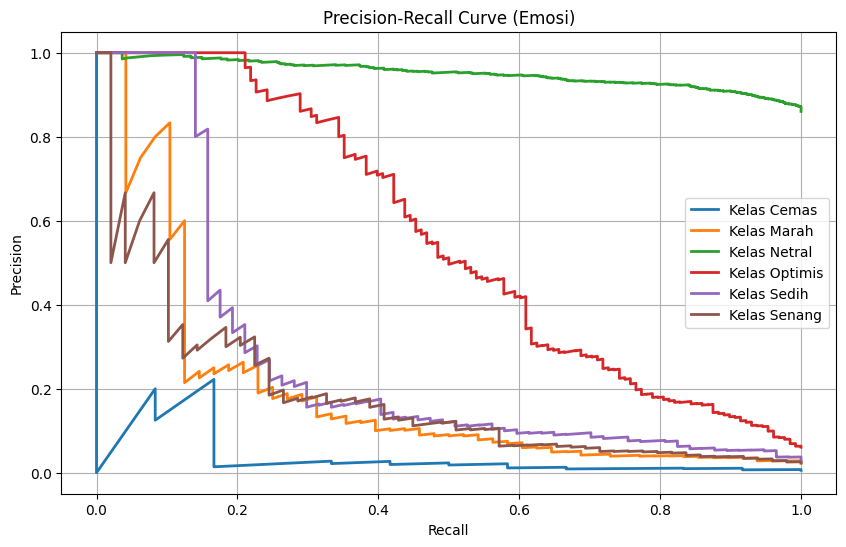

In [15]:
# --- A. LABELING LEXICON (EMOSI) ---
emo_lex = {
    'Marah': {'korupsi', 'bodoh', 'gila', 'kecewa', 'bohong', 'penipu', 'sampah', 'beban', 'bajingan'},
    'Senang': {'bagus', 'keren', 'mantap', 'syukur', 'alhamdulillah', 'senang', 'bahagia', 'suka', 'puas'},
    'Sedih': {'nangis', 'sedih', 'kasihan', 'miris', 'takut', 'bingung', 'susah', 'miskin', 'lapar', 'sakit'},
    'Optimis': {'maju', 'bangkit', 'bisa', 'yakin', 'harapan', 'percaya', 'sukses', 'dukung', 'menang'},
    'Cemas': {'ragu', 'bahaya', 'seram', 'ngeri', 'waspada', 'ancaman', 'panik', 'resah', 'curiga', 'utang'}
}

def get_emotion(text):
    words = text.split()
    scores = {k: 0 for k in emo_lex.keys()}
    for w in words:
        for emo, keys in emo_lex.items():
            if w in keys: scores[emo] += 1
    max_val = max(scores.values())
    if max_val == 0: return 'Netral'
    for emo, sc in scores.items():
        if sc == max_val: return emo

df['label_emo'] = df['text_clean'].apply(get_emotion)

# --- B. VISUALISASI DASAR ---
print("\n📊 Visualisasi Label Emosi:")
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='label_emo', data=df, palette='husl', order=df['label_emo'].value_counts().index)
plt.title('Distribusi Emosi (Bar)')
plt.subplot(1, 2, 2)
df['label_emo'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('husl'))
plt.title('Persentase Emosi (Pie)')
plt.show()

# Word Cloud (Kelompok Negatif vs Positif)
# Negatif: Marah, Sedih, Cemas | Positif: Senang, Optimis
neg_txt = df[df['label_emo'].isin(['Marah', 'Sedih', 'Cemas'])]['text_clean']
pos_txt = df[df['label_emo'].isin(['Senang', 'Optimis'])]['text_clean']

if not neg_txt.empty: plot_wc(neg_txt, "Topik Emosi NEGATIF (Marah/Sedih/Cemas)", 'magma')
if not pos_txt.empty: plot_wc(pos_txt, "Topik Emosi POSITIF (Senang/Optimis)", 'summer')

# --- C. TRAINING MODEL (ML vs DL) ---
print("\n🤖 Sedang Melatih Model untuk Emosi (Mohon Tunggu)...")
# Split Data
y = df['label_emo']
le_emo = LabelEncoder()
y_enc = le_emo.fit_transform(y)
num_classes = len(le_emo.classes_)
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42)

# 1. Machine Learning
X_train_vec = vec.fit_transform(X_train) # vec udah didefine di atas
X_test_vec = vec.transform(X_test)
model_nb_emo = MultinomialNB()
model_nb_emo.fit(X_train_vec, y_train)
y_pred_nb = model_nb_emo.predict(X_test_vec)
acc_ml = accuracy_score(y_test, y_pred_nb)

# 2. Deep Learning
X_tr_dl, X_te_dl, y_tr_dl, y_te_dl = train_test_split(X_lstm, pd.get_dummies(y_enc).values, test_size=0.2, random_state=42)
model_lstm_emo = Sequential()
model_lstm_emo.add(Embedding(5000, 100, input_length=50))
model_lstm_emo.add(SpatialDropout1D(0.2))
model_lstm_emo.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model_lstm_emo.add(Dense(num_classes, activation='softmax'))
model_lstm_emo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm_emo.fit(X_tr_dl, y_tr_dl, epochs=3, batch_size=64, verbose=1)
acc_dl = model_lstm_emo.evaluate(X_te_dl, y_te_dl, verbose=0)[1]

# --- D. EVALUASI LENGKAP (EMOSI) ---
print("\n📈 --- HASIL EVALUASI LABEL EMOSI ---")

# 1. Perbandingan ML vs DL
plt.figure(figsize=(6, 4))
sns.barplot(x=['Naive Bayes', 'LSTM (DL)'], y=[acc_ml*100, acc_dl*100], palette=['skyblue', 'orange'])
plt.title('Perbandingan Akurasi: ML vs DL (Emosi)')
plt.ylabel('Akurasi (%)'); plt.ylim(0, 100)
for i, v in enumerate([acc_ml*100, acc_dl*100]): plt.text(i, v+2, f"{v:.2f}%", ha='center', fontweight='bold')
plt.show()

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_emo.classes_, yticklabels=le_emo.classes_)
plt.title('Confusion Matrix (Emosi)')
plt.show()

# 3. Laporan Metrik
print("Detail Metrik Evaluasi:")
print(classification_report(y_test, y_pred_nb, target_names=le_emo.classes_))

# 4. Threshold (Precision-Recall Curve)
y_prob = model_nb_emo.predict_proba(X_test_vec)
y_test_bin = label_binarize(y_test, classes=range(num_classes))
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    prec, rec, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    plt.plot(rec, prec, lw=2, label=f'Kelas {le_emo.classes_[i]}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve (Emosi)'); plt.legend(); plt.grid()
plt.show()